#### Steps:

- read FoR dataset from files (easy)
- preprocess into spectrograms (hard, many decisions)
- batches & epochs (ez, padding?)
- train & val

#### How to preprocess spectrograms?

Idea: compare different approaches. VGG model only does it in a single way, maybe we can compare some input data augmentations.

Related papers:
- https://arxiv.org/pdf/1904.08779.pdf (see the tutorial NB for time & frequency masking)
- How do these different approaches affect the performance of DeepSonar?

Then, for the fake voice generator, pick the best one.

Other things to try for data loading:
- Use VGG implementation
- Use tf implementation
- Compare
- Mode = train or eval?
- pad with each batch?

Step 1: check VGG model's preprocessing vs. tf's.

In [21]:
import sys
sys.path.append('../old_code')

In [22]:
# VGG implementation lives in data_prep.py
# not sure how to install librosa on anaconda/windows...
from data_prep import load_data

In [23]:
import os
dirname = "D:/for-norm/training/real"
example = "file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"

example_path = os.path.join(dirname, example)

os.path.exists(example_path), example_path

(True,
 'D:/for-norm/training/real\\file1.wav_16k.wav_norm.wav_mono.wav_silence.wav')

In [24]:
features = load_data(example_path, mode='train')
features.shape

(257, 250)

In [25]:
features

array([[-0.31152576, -0.33451185, -0.3648524 , ..., -0.3138902 ,
        -0.29536012, -0.2922517 ],
       [-0.31583488, -0.31112194, -0.36886847, ..., -0.31864062,
        -0.3005375 , -0.30805826],
       [-0.32530645, -0.30091676, -0.3177491 , ..., -0.31397316,
        -0.29464164, -0.26615658],
       ...,
       [-0.33325616, -0.34662142, -0.3706397 , ..., -0.32423526,
        -0.32107657, -0.32972673],
       [-0.33317322, -0.34667143, -0.37072358, ..., -0.32429942,
        -0.32100865, -0.32962796],
       [-0.33313066, -0.3467064 , -0.37068424, ..., -0.3244045 ,
        -0.32100123, -0.3296901 ]], dtype=float32)

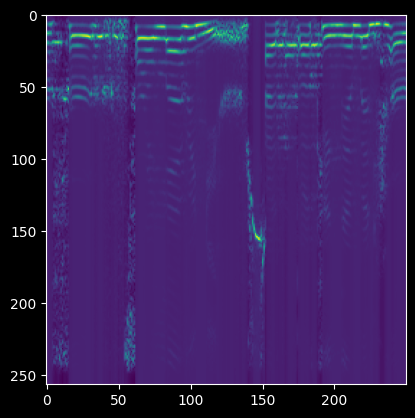

In [26]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.imshow(features)

In [27]:
def vgg_prep(path="D:/for-norm/training/real\\file1.wav_16k.wav_norm.wav_mono.wav_silence.wav", mode="train"):
    features = load_data(example_path, mode=mode)
    plt.imshow(features)

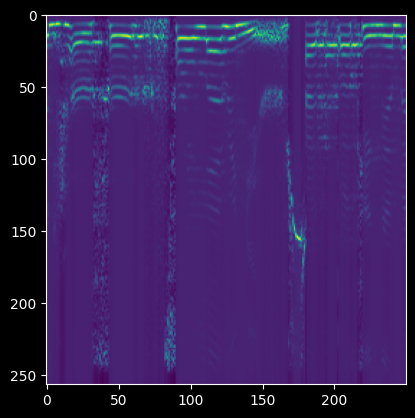

In [28]:
vgg_prep(mode='train')

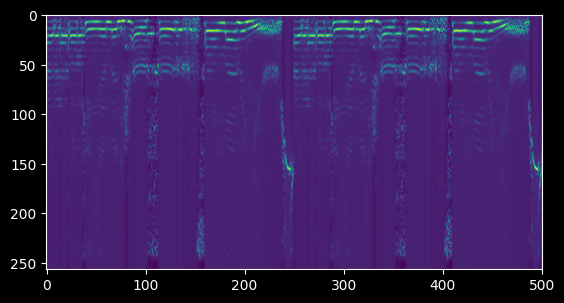

In [29]:
vgg_prep(mode='eval')

In [30]:
import tensorflow as tf
import tensorflow_io as tfio

In [31]:
audio = tfio.audio.AudioIOTensor(example_path)
audio

<AudioIOTensor: shape=[40026     1], dtype=<dtype: 'int16'>, rate=16000>

In [32]:
audio_slice = audio[0:]

# remove last dimension
audio_tensor = tf.squeeze(audio_slice, axis=[-1])

print(audio_tensor)

tf.Tensor([-1074 -1140 -1007 ... -1642  -930  2144], shape=(40026,), dtype=int16)


In [33]:
from IPython.display import Audio

Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

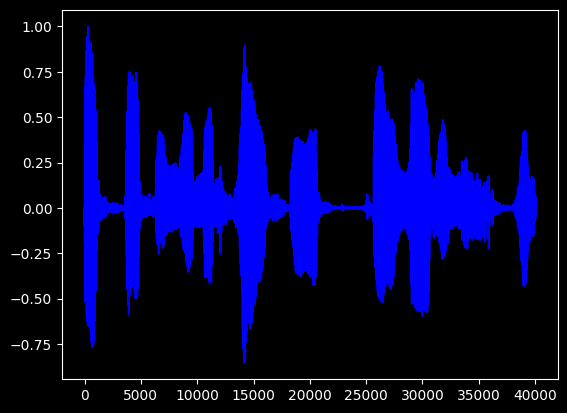

In [34]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')


tensor = tf.cast(audio_tensor, tf.float32) / 32768.0

plt.figure()
plt.plot(tensor.numpy(), "b")

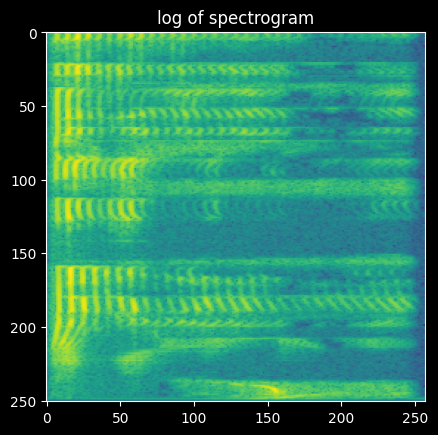

In [35]:
# Convert fade to spectrogram
# def __init__(self, list_IDs, labels, mp_pooler=None, dim=(257, 250, 1), augmentation=True, batch_size=64, nfft=512, spec_len=250,
#                  win_length=400, sampling_rate=16000, hop_length=160, n_classes=5994, shuffle=True, normalize=True):

# use parameters from VGG implementation
spectrogram = tfio.audio.spectrogram(tensor, nfft=512, window=400, stride=160)

plt.figure()
plt.title("log of spectrogram")
plt.imshow(tf.math.log(spectrogram).numpy())

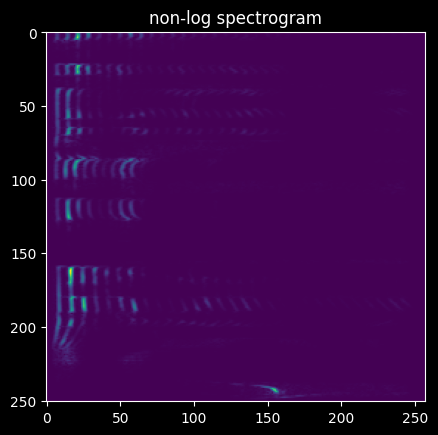

In [36]:
# Show the non-log version of the spectrogram
# This one seems to be more similar to the VGG implementation
plt.figure()
plt.title("non-log spectrogram")
plt.imshow(spectrogram.numpy())

In [37]:
spectrogram.shape

TensorShape([251, 257])

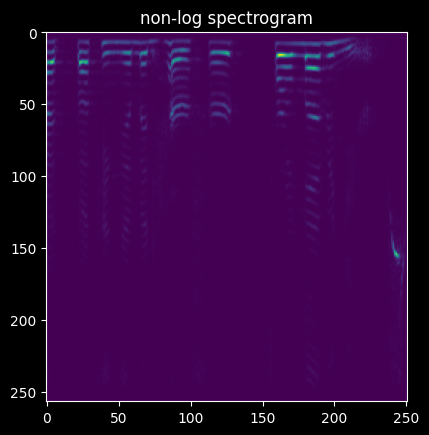

In [38]:
# looks like tf version and librosa version are transposed
plt.figure()
plt.title("non-log spectrogram")
plt.imshow(tf.transpose(spectrogram).numpy())

In [39]:
tf.transpose(spectrogram)

<tf.Tensor: shape=(257, 251), dtype=float32, numpy=
array([[1.6607106e-02, 4.6212167e-02, 2.1922588e-03, ..., 1.0610536e-02,
        3.4609415e-02, 1.1486938e-03],
       [1.9845104e-02, 6.9535673e-02, 3.9900128e-02, ..., 4.6952739e-03,
        3.8079854e-02, 1.1498099e-03],
       [9.5513791e-02, 8.3516769e-02, 5.2981548e-02, ..., 3.3919476e-02,
        4.1206378e-02, 1.1530911e-03],
       ...,
       [2.0904893e-04, 8.8243868e-04, 8.7359105e-04, ..., 6.2953192e-03,
        3.6716785e-02, 1.4004639e-03],
       [1.9148516e-05, 5.8494846e-04, 3.7603112e-04, ..., 6.4931773e-03,
        3.6654461e-02, 1.4061428e-03],
       [1.3524294e-04, 8.7568164e-04, 7.1263313e-04, ..., 6.4695925e-03,
        3.6691971e-02, 1.4080635e-03]], dtype=float32)>

### So, the data loading is going to be a bit complex.

The spectrograms are generated in different ways depending on whether we use librosa or tensorflow. So, let's prepare the data in both ways. See the tf.data tutorials for details. We'll start by loading the data with tensorflow operations.

#### 1. We'll consume the dataset from sets of files stored on this PC.

Apply this part of the tf.data tutorial (see on Colab) to your files.

In [40]:
# need to go one level deeper to match example
import pathlib
train_path = "D:/for-norm/training/"
train_path = pathlib.Path(train_path)
for item in train_path.glob("*"):
    print(item.name)

fake
real


In [41]:
list_ds = tf.data.Dataset.list_files(str(train_path/'*/*'))

for f in list_ds.take(5):
    print(f.numpy())

b'D:\\for-norm\\training\\real\\file4516.wav_16k.wav_norm.wav_mono.wav_silence.wav'
b'D:\\for-norm\\training\\fake\\file31510.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav'
b'D:\\for-norm\\training\\fake\\file4054.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav'
b'D:\\for-norm\\training\\real\\file4276.wav_16k.wav_norm.wav_mono.wav_silence.wav'
b'D:\\for-norm\\training\\fake\\file8643.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav'


In [42]:
def process_path(file_path):
    label = tf.strings.split(file_path, os.sep)[-2]
    return tf.io.read_file(file_path), label

labeled_ds = list_ds.map(process_path)
for audio_raw, label_text in labeled_ds.take(1):
    print(repr(audio_raw.numpy()[:100]))
    print()
    print(label_text.numpy())

b'RIFF(\x92\x04\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80>\x00\x00\x00}\x00\x00\x02\x00\x10\x00data\x04\x92\x04\x00\xf7\x0c\x99\x0c\xb7\x0b\x85\t\xef\x06\xb0\x04^\x02P\x00\xfa\xfcU\xfb\xea\xf9\xe0\xf7\\\xf6\x1c\xf6\xbb\xf5\xb3\xf5\xe3\xf4\xf3\xf3\x12\xf3:\xf1*\xef\x03\xf1\xde\xf2F\xf4\xa1\xf4\x16\xf5:\xf4\xe4\xf4'

b'real'


#### 2. Preprocess the audio into spectrograms.

Try this part with both tensorflow and librosa, if necessary.

In [43]:
def parse_audio(filename):
    """
    Reads audio from a file and converts it to a spectrogram.
    Uses all tf operations for speed.
    """
    parts = tf.strings.split(filename, os.sep)
    label = parts[-2]

    audio = tf.io.read_file(filename)
    # audio = tf.squeeze(audio[0:], axis=[-1])
    # audio = tf.cast(audio, tf.float32) / 32768.0
    # audio = tfio.audio.spectrogram(audio, nfft=512, window=400, stride=160)

    print(f"audio = {type(audio)}, label = {label}")
    return audio, label

In [44]:
list_ds = tf.data.Dataset.list_files(str(train_path/'*/*')) # rebuild list ds
file_path = next(iter(list_ds))
audio, label = parse_audio(file_path)

# def show(audio, label):
#     plt.figure()
#     plt.imshow(audio)
#     plt.title(label.numpy().decode('utf-8'))
#     plt.axis('off')

# show(audio, label)

audio = <class 'tensorflow.python.framework.ops.EagerTensor'>, label = b'real'


## New idea: start from baseline and slowly build up.

- Random guessing

- Classifier from simple audio tutorial on tensorflow ->  https://www.tensorflow.org/tutorials/audio/simple_audio

- SVM, e.g., is fake voice detection going in the right direction?

- DeepSonar

- Autoencoder

### Start by evaluating with the random baseline.

Let's get the datasets and evaluate on some metrics. Evaluating early will help us later on.

Evaluation metrics:
* Accuracy; we want to see how accurately the model performs, and the classes are balanced so this is a useful metric.

* Precision; we want to be certain that our predicted positives (predicted real voices) are indeed positive (real). This is because we don't want to allow an attacker with a fake voice to potentially access our system.

* Recall = TPR; in our case, this means that we don't want to deny access to a person who actually has a real voice, e.g., misclassify someone who has a real voice as having a fake voice. I guess this is important because they would wrongly be denied access, but IMO precision is more important.

* $F_1$; we care about both precision and recall, so their harmonic mean is a good idea.

* $F_\beta$; we may want to care a bit more about precision than recall so that we can prevent the attackers as our main priority. For $ F_1, \beta = 1 $. Set beta less than 1 if you want to weight precision more, and set beta greater than 1 if you want to weight recall more.

* FPR

* FNR

* AUC

* EER

Which class is positive and negative? See src/Labels.py.

In [45]:
import os, pathlib
train_path = pathlib.Path("D:/for-norm/training")
os.path.exists(train_path), train_path

(True, WindowsPath('D:/for-norm/training'))

In [46]:
val_path = pathlib.Path("D:/for-norm/validation")
test_path = pathlib.Path("D:/for-norm/testing")
os.path.exists(val_path), os.path.exists(test_path)

(True, True)

In [47]:
import sys
sys.path.append('../src')
from Labels import Labels

In [48]:
# generate random predictions in {0, 1}
import numpy as np
real_examples = os.listdir(os.path.join(train_path, "real"))
fake_examples = os.listdir(os.path.join(train_path, "fake"))
num_train_samples = len(real_examples) + len(fake_examples)
random_train_preds = np.squeeze(np.array([np.random.randint(low=0, high=2, size=num_train_samples)]).astype(float))
random_train_preds.shape, random_train_preds[:5]

((53868,), array([0., 1., 1., 0., 0.]))

In [49]:
# get the labels
real_labels = np.array([float(Labels.REAL.value) for _ in range(len(real_examples))])
fake_labels = np.array([float(Labels.FAKE.value) for _ in range(len(fake_examples))])
train_labels = np.concatenate((real_labels, fake_labels))

# shuffle the labels to simulate what would happen in real training
# we would not feed all the real examples, then all the fake examples to the network
np.random.shuffle(train_labels)

train_labels.shape, train_labels[:5]

((53868,), array([0., 0., 1., 0., 0.]))

In [50]:
# check metrics of random predictions (early evaluation!)
import tensorflow as tf
confusion_matrix = tf.math.confusion_matrix(
    labels=train_labels,
    predictions=random_train_preds,
    num_classes=2
)
confusion_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[13289, 13638],
       [13359, 13582]])>

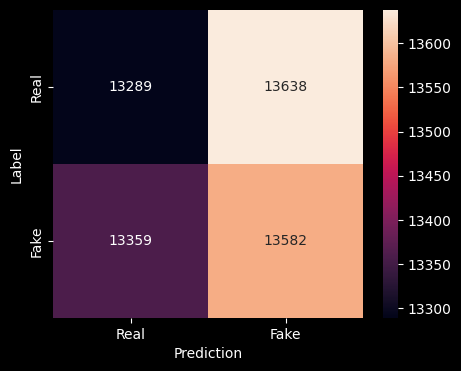

In [51]:
# plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.figure(figsize=(5, 4))
classes = np.array(["Real", "Fake"])
sns.heatmap(confusion_matrix,
            xticklabels=classes,
            yticklabels=classes,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

$ Accuracy = \dfrac{TP + TN}{TP + TN + FP + FN} $

This is just the training accuracy.

In [52]:
accuracy = np.sum(tf.linalg.tensor_diag_part(confusion_matrix)) / np.sum(confusion_matrix)
accuracy * 100

49.883047449320564

$ Precision = \dfrac{TP}{TP + FP} $

In [53]:
positive_column = confusion_matrix[:, 0]
print(positive_column)
precision = positive_column[0].numpy() / np.sum(positive_column)
print(precision * 100)

tf.Tensor([13289 13359], shape=(2,), dtype=int32)
49.86865806064245


$ Recall = \dfrac{TP}{TP + FN} $

In [54]:
positive_row = confusion_matrix[0, :]
print(positive_row)
recall = positive_row[0].numpy() / np.sum(positive_row)
print(recall * 100)

tf.Tensor([13289 13638], shape=(2,), dtype=int32)
49.35195157277082


$ P \coloneqq Precision; R \coloneqq Recall $

$ F_1 = \dfrac{2PR}{P + R} $ (harmonic mean of precision and recall)

In [55]:
f1 = (2 * precision * recall) / (precision + recall)
f1 * 100

49.60895940270648

### Now, let's start preprocessing the data in a more advanced way.

For this one, we can look at the simple audio tutorial on tensorflow.

In [56]:
import numpy as np
train_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=train_path,
    batch_size=64,
    validation_split=0
)
label_names = np.array(train_ds.class_names)
print(f"label names = {label_names}")

Found 53868 files belonging to 2 classes.
label names = ['fake' 'real']


In [57]:
# validation
val_path = pathlib.Path("D:/for-norm/validation")
val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=val_path,
    batch_size=64,
    validation_split=0
)
label_names = np.array(val_ds.class_names)
print(f"label names = {label_names}")

# test
test_path = pathlib.Path("D:/for-norm/testing")
test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=test_path,
    batch_size=64,
    validation_split=0
)
label_names = np.array(test_ds.class_names)
print(f"label names = {label_names}")

Found 10798 files belonging to 2 classes.
label names = ['fake' 'real']
Found 4634 files belonging to 2 classes.
label names = ['fake' 'real']


### Let's preprocess the data exactly as is done in the VGG model.

Start with VGG model in 'eval' mode since we are just selecting the output activations.

Go step by step w/ librosa, tensorflow and see what is happening.

In [58]:
import os
dirname = "D:/for-norm/training/real"
example = "file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"
example_path = os.path.join(dirname, example)
os.path.exists(example_path), example_path

(True,
 'D:/for-norm/training/real\\file1.wav_16k.wav_norm.wav_mono.wav_silence.wav')

1. Load the .wav file

In [60]:
import librosa
sample_rate = 16000
wav, _ = librosa.load(example_path, sr=sample_rate)
wav.shape

(40026,)

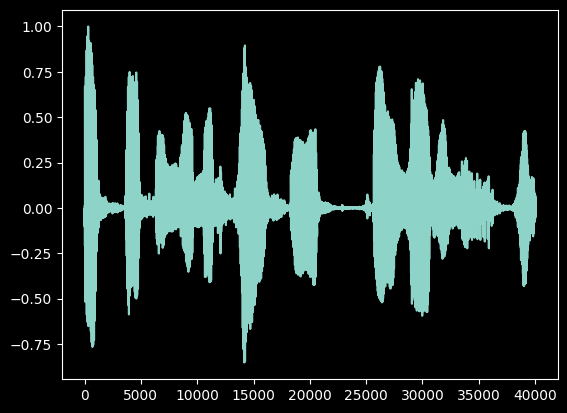

In [61]:
plt.plot(wav)

In [62]:
train_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=train_path,
    batch_size=64,
    validation_split=0, sampling_rate=sample_rate
)

<PaddedBatchDataset element_spec=(TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [64]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 130794, 1)
(64,)


ValueError: x and y can be no greater than 2D, but have shapes (64,) and (64, 130794, 1)

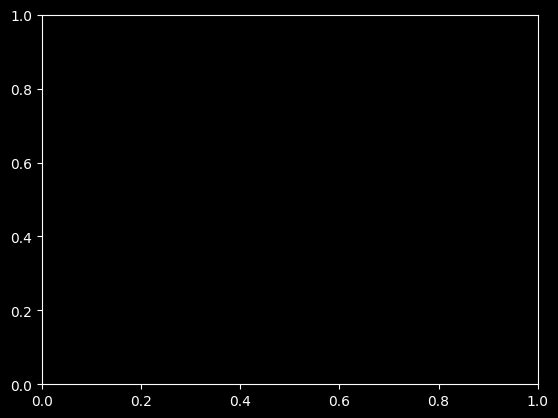

In [65]:
plt.plot(example_audio.numpy())